In [1]:
import math
import pandas as pd

In [2]:
mol_wt = 500
half_time_dissolution = 0.1    # hours
half_time_absorption = 2    # hours
half_time_elimination = 0.25    # hours
bioavailability = 0.38    # fraction of absorbed
volume_distribution = 0.106    # liters per kilogram
human_mass = 75    # kilograms
dose_hours = [0, 12, 24, 36]    # elapsed time that doses are given
dose_mpk = 45    # dose in mg/kg
simulation_duration = 48    # hours to simulate
simulations_per_hour = 60

In [3]:
human_volume = volume_distribution * human_mass
dose_minutes = [dh * 60 for dh in dose_hours]
absolute_dose = dose_mpk * human_mass
sim_interval = int(60 / simulations_per_hour)

In [4]:
def decay(n_initial, half_life, time_elapsed):
    exponent = ((-1) * math.log(2) / half_life) * time_elapsed
    n_final = (n_initial) * math.exp(exponent)
    return n_final, n_initial - n_final

def dissolve(last_state, time_elapsed):
    new_state = last_state
    solid, dissolved = decay(last_state[1], half_time_dissolution, time_elapsed)
    new_state[1] = solid
    new_state[2] += dissolved
    return new_state

def absorb(last_state, time_elapsed):
    new_state = last_state
    dissolved, available = decay(last_state[2], half_time_absorption, time_elapsed)
    absorbed = (available) * bioavailability
    eliminated = available - absorbed
    new_state[2] = dissolved
    new_state[3] += absorbed
    new_state[4] += eliminated
    return new_state

def eliminate_systemic(last_state, time_elapsed):
    new_state = last_state
    absorbed, eliminated = decay(last_state[3], half_time_elimination, time_elapsed)
    new_state[3] = absorbed
    new_state[4] += eliminated
    return new_state

def sim_next_minute(last_state, interval):
    new_state = last_state.copy()
    new_state = dissolve(new_state, interval)
    new_state = absorb(new_state, interval)
    new_state = eliminate_systemic(new_state, interval)
    new_state = calc_plasma_conc(new_state)
    return new_state

def calc_plasma_conc(state):
    mg_per_liter = state[3] / human_volume
    ng_per_ml = mg_per_liter * 1000
    mM = mg_per_liter / mol_wt
    state[5] = mM
    state[6] = ng_per_ml
    return state

In [5]:
col_names = ['time (min)',             'solid (mg)',
             'dissolved (mg)',         'absorbed (mg)',
             'eliminated (mg)',        'plasma_conc (mM)',
             'plasma_conc (ng/mL)',    'time (h)']
pk_data = {cn: list() for cn in col_names}

In [6]:
state = [0] * len(col_names)
timepoints = list(range(0, simulation_duration * 60, sim_interval))
for x in timepoints:
    state[0] = x
    state[7] = x / 60
    if state[0] in dose_minutes:
        state[1] += absolute_dose
    for i, cn in enumerate(col_names):
        pk_data[cn].append(state[i])
    state = sim_next_minute(state, 1/simulations_per_hour)

In [7]:
df1 = pd.DataFrame.from_dict(pk_data)
df1.head(10)

,time (min),solid (mg),dissolved (mg),absorbed (mg),eliminated (mg),plasma_conc (mM),plasma_conc (ng/mL),time (h)
0,0,3375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,3006.783174,366.096053,0.769501,1.351272,0.000194,96.792556,0.016667
2,2,2678.739275,690.142000,2.185368,3.933357,0.000550,274.888996,0.033333
3,3,2386.485387,976.737705,4.139694,7.637215,0.001041,520.716254,0.050000
4,4,2126.116772,1229.981111,6.538061,12.364055,0.001645,822.397662,0.066667
5,5,1894.154707,1453.523004,9.297987,18.024303,0.002339,1169.558119,0.083333
6,6,1687.500000,1650.615790,12.347550,24.536660,0.003106,1553.150956,0.100000
7,7,1503.391587,1824.156969,15.624168,31.827276,0.003931,1965.304106,0.116667
8,8,1339.369638,1976.727851,19.073509,39.829003,0.004798,2399.183472,0.133333
9,9,1193.242693,2110.628051,22.648529,48.480727,0.005698,2848.871570,0.150000


<AxesSubplot:title={'center':'Simulated Human PK'}, xlabel='time (h)', ylabel='Plasma Conc. (ng/mL)'>

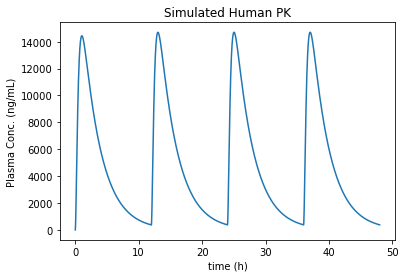

In [8]:
df1.plot(x='time (h)', y='plasma_conc (ng/mL)', title='Simulated Human PK',
         legend=False, ylabel='Plasma Conc. (ng/mL)')